In [1]:
import numpy    as np
from numpy.testing._private.utils import decorate_methods
import pandas   as pd
import seaborn  as sns
import matplotlib.pyplot as plt
import sklearn  as skl
import time

from sklearn.pipeline import Pipeline      # Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, plot_confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import set_config
set_config(display='diagram') # Useful for display the pipeline

from sklearn.tree          import DecisionTreeRegressor
from sklearn.ensemble      import RandomForestRegressor
from sklearn.ensemble      import ExtraTreesRegressor
from sklearn.ensemble      import AdaBoostRegressor
from sklearn.ensemble      import GradientBoostingRegressor
from xgboost               import XGBRegressor
from lightgbm              import LGBMRegressor
from catboost              import CatBoostRegressor

In [2]:
data = pd.read_csv(r'data\london_merged.csv')
data['year'] = data['timestamp'].apply(lambda row: row[:4])
data['month'] = data['timestamp'].apply(lambda row: row.split('-')[2][:2] )
data['hour'] = data['timestamp'].apply(lambda row: row.split(':')[0][-2:] )
data.drop('timestamp', axis=1, inplace=True)
data.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,year,month,hour
0,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,2015,04,00
1,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,2015,04,01
2,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2015,04,02
3,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,2015,04,03
4,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,2015,04,04


In [3]:
wind_chill_t3 = []
for i in data.index:
    temp = (data['t1'].iloc[i]*(9/5))+32
    wind = (data['wind_speed'].iloc[i])*0.6213
    if wind>0:
        wind_chill = 35.74+(0.6215*temp)-(35.75*(wind**0.16))+(0.4275*temp*(wind**0.16))
        c_wc = (wind_chill-32)*(5/9)
        wind_chill_t3.append(round(c_wc,1))
    else:
        wind_chill_t3.append(0)
wind_chill_t3[2]
data['t3'] = wind_chill_t3
data.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,year,month,hour,t3
0,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,2015,04,00,1.4
1,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,2015,04,01,1.8
2,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2015,04,02,0.0
3,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,2015,04,03,0.0
4,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,2015,04,04,0.1


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'is_holiday'),
  Text(0, 1, 'is_weekend'),
  Text(0, 2, 'season'),
  Text(0, 3, 'wind_speed'),
  Text(0, 4, 'weather_code'),
  Text(0, 5, 't2'),
  Text(0, 6, 't3'),
  Text(0, 7, 't1'),
  Text(0, 8, 'hum'),
  Text(0, 9, 'cnt')])

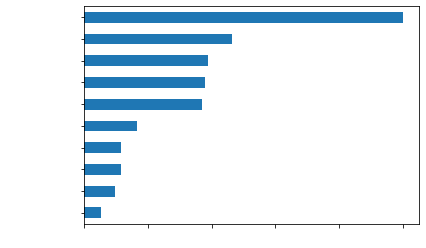

In [4]:
%matplotlib inline
data.corr()['cnt'].abs().sort_values().plot(kind = 'barh')
plt.xticks(color = 'white')
plt.yticks(color = 'white')

In [5]:
def data_enhancement(data):
    
    gen_data = data
    
    for season in data['season'].unique():
        seasonal_data =  gen_data[gen_data['season'] == season]
        hum_std = seasonal_data['hum'].std()
        #wind_speed_std = seasonal_data['wind_speed'].std()
        t1_std = seasonal_data['t1'].std()
        t2_std = seasonal_data['t2'].std()
        t3_std = seasonal_data['t3'].std()
        
        for i in gen_data[gen_data['season'] == season].index:
            if np.random.randint(2) == 1:
                gen_data['hum'].values[i] += hum_std/10
            else:
                gen_data['hum'].values[i] -= hum_std/10
                
            # if np.random.randint(2) == 1:
            #     gen_data['wind_speed'].values[i] += wind_speed_std/10
            # else:
            #     gen_data['wind_speed'].values[i] -= wind_speed_std/10
                
            if np.random.randint(2) == 1:
                gen_data['t1'].values[i] += t1_std/10
            else:
                gen_data['t1'].values[i] -= t1_std/10
                
            if np.random.randint(2) == 1:
                gen_data['t2'].values[i] += t2_std/10
            else:
                gen_data['t2'].values[i] -= t2_std/10.

            if np.random.randint(2) == 1:
                gen_data['t3'].values[i] += t3_std/10
            else:
                gen_data['t3'].values[i] -= t3_std/10

    return gen_data

print(data.head(3))
gen = data_enhancement(data)
print(gen.head(3) )

   cnt   t1   t2   hum  wind_speed  weather_code  is_holiday  is_weekend  \
0  182  3.0  2.0  93.0         6.0           3.0         0.0         1.0   
1  138  3.0  2.5  93.0         5.0           1.0         0.0         1.0   
2  134  2.5  2.5  96.5         0.0           1.0         0.0         1.0   

   season  year month hour   t3  
0     3.0  2015    04   00  1.4  
1     3.0  2015    04   01  1.8  
2     3.0  2015    04   02  0.0  
   cnt        t1       t2        hum  wind_speed  weather_code  is_holiday  \
0  182  3.379372  1.51169  94.089517         6.0           3.0         0.0   
1  138  2.620628  2.01169  91.910483         5.0           1.0         0.0   
2  134  2.120628  2.01169  97.589517         0.0           1.0         0.0   

   is_weekend  season  year month hour        t3  
0         1.0     3.0  2015    04   00  1.821398  
1         1.0     3.0  2015    04   01  2.221398  
2         1.0     3.0  2015    04   02  0.421398  


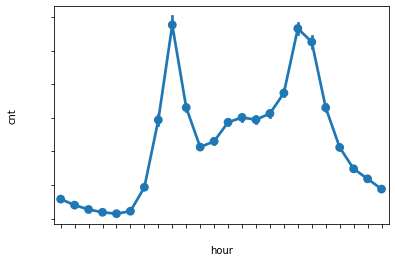

In [6]:
sns.pointplot(x='hour', y='cnt', data=data)
plt.xticks(color= 'white')
plt.yticks(color = 'white')
plt.show()

In [7]:
y = data['cnt']
x = data.drop(['cnt'], axis=1)


cat_vars = ['year','month','weather_code', 'season', 'hour']
num_vars = ['t1','t2','hum', 't3', 'wind_speed']


x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2,random_state=0) # Recommended for reproducibility

extra_sample = gen.sample(gen.shape[0] // 3)
x_train = pd.concat([x_train, extra_sample.drop(['cnt'], axis=1 ) ])
y_train = pd.concat([y_train, extra_sample['cnt'] ])

transformer = PowerTransformer()
y_train = transformer.fit_transform(y_train.values.reshape(-1,1))
y_val = transformer.transform(y_val.values.reshape(-1,1))                     

In [8]:
num_4_treeModels = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-9999)),
])

cat_4_treeModels = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ordinal', OrdinalEncoder()) # handle_unknown='ignore' ONLY IN VERSION 0.24
])

tree_prepro = ColumnTransformer(transformers=[
    ('num', num_4_treeModels, num_vars),
    ('cat', cat_4_treeModels, cat_vars),
], remainder='drop') # Drop other vars not specified in num_vars or cat_vars

In [9]:
tree_classifiers = {
  "Decision Tree": DecisionTreeRegressor(),
  "Extra Trees":   ExtraTreesRegressor(n_estimators=100),
  "Random Forest": RandomForestRegressor(n_estimators=100),
  "AdaBoost":      AdaBoostRegressor(n_estimators=100),
  "Skl GBM":       GradientBoostingRegressor(n_estimators=100),
  "XGBoost":       XGBRegressor(n_estimators=100),
  "LightGBM":      LGBMRegressor(n_estimators=100),
  "CatBoost":      CatBoostRegressor(n_estimators=100),
}

tree_classifiers = {name: make_pipeline(tree_prepro, model) for name, model in tree_classifiers.items()}

results = pd.DataFrame({'Model': [],'r_score':[], 'MSE': [], 'MAB': [], " % error": [], 'Time': []})

In [10]:
rang = abs(y_train.max()) + abs(y_train.min())
for model_name, model in tree_classifiers.items():
    
    start_time = time.time()
    model.fit(x_train, y_train)
    total_time = time.time() - start_time
        
    pred = model.predict(x_val)
    
    results = results.append({"Model":    model_name,
                              "r_score": r2_score(y_val, pred),
                              "MSE": mean_squared_error(y_val, pred),

                              "MAB": mean_absolute_error(y_val, pred),
                              " % error": mean_squared_error(y_val, pred) / rang,
                              "Time":     total_time},
                              ignore_index=True)

results_ord = results.sort_values(by=['MSE'], ascending=True, ignore_index=True)
results_ord.index += 1 
results_ord.style.bar(subset=['MSE', 'MAE'], vmin=0, vmax=100, color='#5fba7d')

print(results_ord)

C:\Users\rnr31\anaconda3\envs\ds22\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\rnr31\anaconda3\envs\ds22\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\rnr31\anaconda3\envs\ds22\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\rnr31\anaconda3\envs\ds22\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d 

Learning rate set to 0.42641
0:	learn: 0.7236178	total: 153ms	remaining: 15.1s
1:	learn: 0.5774755	total: 163ms	remaining: 7.97s
2:	learn: 0.5158466	total: 174ms	remaining: 5.61s
3:	learn: 0.4752695	total: 181ms	remaining: 4.34s
4:	learn: 0.4563450	total: 192ms	remaining: 3.64s
5:	learn: 0.4464230	total: 202ms	remaining: 3.16s
6:	learn: 0.4400669	total: 214ms	remaining: 2.85s
7:	learn: 0.4365922	total: 219ms	remaining: 2.52s
8:	learn: 0.4319812	total: 225ms	remaining: 2.27s
9:	learn: 0.4298827	total: 240ms	remaining: 2.15s
10:	learn: 0.4280198	total: 254ms	remaining: 2.06s
11:	learn: 0.4262432	total: 263ms	remaining: 1.93s
12:	learn: 0.4243161	total: 272ms	remaining: 1.82s
13:	learn: 0.4232112	total: 286ms	remaining: 1.75s
14:	learn: 0.4195507	total: 295ms	remaining: 1.67s
15:	learn: 0.4183666	total: 318ms	remaining: 1.67s
16:	learn: 0.4170915	total: 339ms	remaining: 1.65s
17:	learn: 0.4159181	total: 347ms	remaining: 1.58s
18:	learn: 0.4155034	total: 364ms	remaining: 1.55s
19:	learn: 0

In [11]:
results_ord

,Model,r_score,MSE,MAB,% error,Time
1,Extra Trees,0.879005,0.120325,0.199634,0.021793,7.397111
2,Random Forest,0.872153,0.127139,0.232207,0.023027,11.995318
3,XGBoost,0.851436,0.147741,0.272685,0.026759,1.592831
4,CatBoost,0.842860,0.156269,0.287165,0.028303,1.676394
5,LightGBM,0.840955,0.158164,0.288819,0.028647,0.812790
6,Skl GBM,0.819569,0.179431,0.311688,0.032499,3.918433
7,Decision Tree,0.790989,0.207853,0.234877,0.037646,0.496655
8,AdaBoost,0.724949,0.273527,0.422746,0.049541,1.649072
